## imports

In [111]:
# set plots inline for ipython
%matplotlib inline

# general python imports
from time import time

# Standard scientific Python imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
plt.style.use('fivethirtyeight')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# import datasets, preprocessing, piplining, evaluation
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from sklearn.metrics import accuracy_score
from scipy.stats import variation


# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM


# dimensionality reduction
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection 
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Supervised learning
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


In [112]:
# set the figure sizes
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'figure.figsize': (4,3)})

## load data

In [113]:
# load data
cancer=pd.read_csv('breast-cancer-w-diag.csv', header=0)
cancer.drop('id',axis=1,inplace=True)
cancer.drop('Unnamed: 32',axis=1,inplace=True)
cancer['diagnosis'] = cancer['diagnosis'].map({'M':1,'B':0})

In [114]:
train,test=train_test_split(cancer,test_size=0.2,random_state=0,stratify=cancer['diagnosis'])# stratify the outcome
X=train[train.columns[1:31]] # X train
X_test=test[test.columns[1:31]]
y=train['diagnosis'] # y train
y_test=test['diagnosis']

# fit a standardScaler to normalize all input to zero mean and unit variance
scaler = StandardScaler().fit(X)
X=scaler.transform(X)
X_test = scaler.transform(X_test)
y = np.array(y)
y_test=np.array(y_test)

In [115]:
print X.shape
print X_test.shape

(455, 30)
(114, 30)


# 1. Clustering

## 1.1 k-means clustering
http://scikit-learn.org/stable/modules/clustering.html

In [116]:
#find optimized cluster number
meandist = []
ARI = []
AMI = []
h_score = []
c_score = []
V_measure = []
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    Z = kmeans.fit_predict(X)
    # cluster average within k-means SSE
    min_ = np.min(np.square(cdist(X, kmeans.cluster_centers_, 'euclidean')), axis = 1)
    value = np.mean(min_)
    meandist.append(value)
    # other scores
    ARI.append(metrics.adjusted_rand_score(y, Z))
    AMI.append(metrics.adjusted_mutual_info_score(y, Z))
    h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
    h_score.append(h)
    c_score.append(c)
    V_measure.append(V)

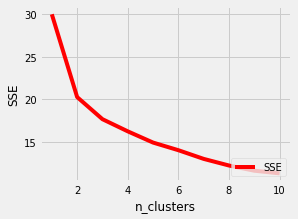

In [117]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, meandist, color='red', label='SSE')

plt.legend(loc='lower right')
#plt.title("KNN: unweighted (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('SSE');
plt.show()

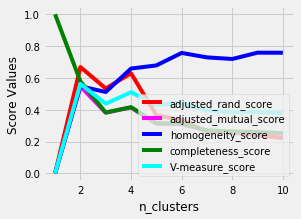

In [118]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ARI, color='red', label='adjusted_rand_score')
plt.plot(k, AMI, color='magenta', label='adjusted_mutual_score')
plt.plot(k, h_score, color='blue', label='homogeneity_score')
plt.plot(k, c_score, color='green', label='completeness_score')
plt.plot(k, V_measure, color='cyan', label='V-measure_score')

plt.legend(loc='lower right')
#plt.title("KNN: unweighted (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('Score Values');
plt.show()

## 1.2 EM clustering

In [119]:
#find optimized cluster number
ll = [] # log likelyhood
ARI = []
AMI = []
h_score = []
c_score = []
V_measure = []
bic = []
aic = []
for k in range(1,11):
    gmm = GMM(n_components=k, covariance_type='spherical')
    gmm.fit(X)
    Z = gmm.predict(X)
    ll.append(gmm.score(X))
    ARI.append(metrics.adjusted_rand_score(y, Z))
    AMI.append(metrics.adjusted_mutual_info_score(y, Z))
    h, c, V = metrics.homogeneity_completeness_v_measure(y, Z)
    h_score.append(h)
    c_score.append(c)
    V_measure.append(V)
    bic.append(gmm.bic(X))
    aic.append(gmm.aic(X))

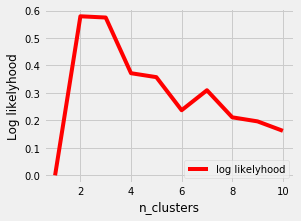

In [120]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ARI, color='red', label='log likelyhood')

plt.legend(loc='lower right')
#plt.title("KNN: unweighted (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('Log likelyhood');
plt.show()

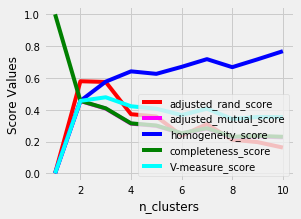

In [121]:
k = [1,2,3,4,5,6,7,8,9,10]
plt.plot(k, ARI, color='red', label='adjusted_rand_score')
plt.plot(k, AMI, color='magenta', label='adjusted_mutual_score')
plt.plot(k, h_score, color='blue', label='homogeneity_score')
plt.plot(k, c_score, color='green', label='completeness_score')
plt.plot(k, V_measure, color='cyan', label='V-measure_score')

plt.legend(loc='lower right')
#plt.title("KNN: unweighted (Cancer)")
#plt.ylim(0.92, 1.01)
#plt.xticks(np.arange(0,2.1,0.5))
plt.xlabel('n_clusters')
plt.ylabel('Score Values');
plt.show()

## 1.3 Compare k means and EM

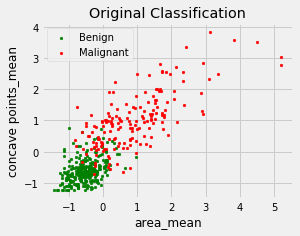

In [122]:
# original class

k = 2 # number of clusters
colors = ['g', 'r', 'b', 'y', 'c', 'm']
labels = ['Benign', 'Malignant']
fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X[j] for j in range(len(X)) if y[j] == i])
    ax.scatter(points[:, 3], points[:, 7], s=7, c=colors[i], label=labels[i])
plt.xlabel("area_mean")
plt.ylabel("concave points_mean")
plt.legend(loc=2)
plt.title('Original Classification')

time:  0.0320539474487
wrongly labeled: 0.90989010989


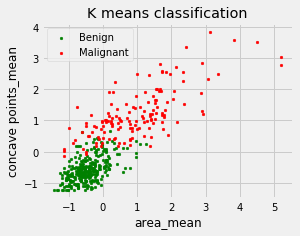

In [123]:
# K means classification
start = time()
clf = KMeans(init='k-means++', n_clusters=2, random_state=42)
clf.fit_predict(X)
print 'time: ', time() - start

# fix labels
clusters_kmeans = np.choose(clf.labels_, [1, 0])

k = 2 # number of clusters
colors = ['g', 'r', 'b', 'y', 'c', 'm']
labels = ['Benign', 'Malignant']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X[j] for j in range(len(X)) if clf.labels_[j] == i])
    ax.scatter(points[:, 3], points[:, 7], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_kmeans[j]])
#ax.scatter(points[:, 3], points[:, 7], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("area_mean")
plt.ylabel("concave points_mean")
plt.legend(loc=2)
plt.title('K means classification')
print 'wrongly labeled:', 1.0*len(points)/len(X)

time:  0.00758790969849
wrongly labeled: 0.118681318681


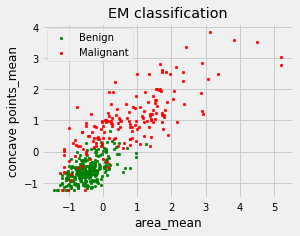

In [124]:
# EM classification
start = time()
clf = GMM(n_components=2, covariance_type='spherical', random_state=42)
clf.fit(X)
clusters_EM = clf.predict(X)
print 'time: ', time() - start

# fix labels
#clusters_EM = np.choose(clusters_EM, [1, 0])

k = 2 # number of clusters
colors = ['g', 'r', 'b', 'y', 'c', 'm']
labels = ['Benign', 'Malignant']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X[j] for j in range(len(X)) if clusters_EM[j] == i])
    ax.scatter(points[:, 3], points[:, 7], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_EM[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("area_mean")
plt.ylabel("concave points_mean")
plt.legend(loc=2)
plt.title('EM classification')
print 'wrongly labeled:', 1.0*len(points)/len(X)

# 2. Dimensionality Reduction

## 2.1 PCA

### PCA - select pca parameter

In [125]:
pca = PCA()
pca.fit(X)
print pca.explained_variance_ratio_

[  4.45454545e-01   1.85448704e-01   9.90831818e-02   6.51567607e-02
   5.37436250e-02   3.84563412e-02   2.33120568e-02   1.59084644e-02
   1.41334599e-02   1.16610179e-02   9.60041499e-03   8.89355380e-03
   7.70617662e-03   4.59602101e-03   3.13887853e-03   2.67828805e-03
   2.06513860e-03   1.89340236e-03   1.62225436e-03   1.05520439e-03
   9.51357685e-04   9.10161122e-04   8.38992627e-04   5.99519693e-04
   5.11511518e-04   2.77413528e-04   2.19859253e-04   5.52386214e-05
   2.45569297e-05   3.90006739e-06]


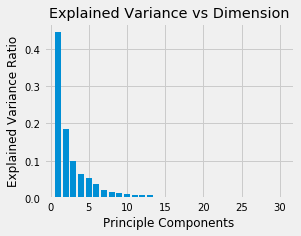

In [126]:
#Plot Variance Ratio for PCA
plt.bar(range(1, 31), pca.explained_variance_ratio_)
plt.xlabel('Principle Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs Dimension')
plt.show()
plt.clf()

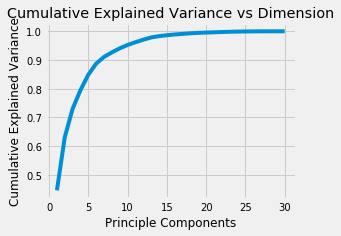

In [127]:
cummulative_explained_variance_ = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 31), cummulative_explained_variance_)
plt.xlabel('Principle Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Dimension')
plt.show()
plt.clf()

In [128]:
acc = []
for i in range (1, 31):
    X_pca = PCA(n_components=i).fit_transform(X)
    #clf = DecisionTreeClassifier(max_depth=5)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_pca, y)
    acc.append(clf.score(X_pca, y))

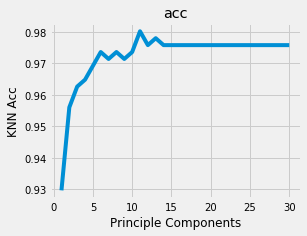

In [129]:
plt.plot(range(1, 31), acc)
plt.xlabel('Principle Components')
plt.ylabel('KNN Acc')
plt.title('acc')
plt.show()
plt.clf()

## 2.2 ICA

### ICA parameter

In [130]:
kurts = []
for i in range (1, 31):
    ica = FastICA(n_components=i, whiten=True)
    output =ica.fit_transform(X)
    kurt = np.average(kurtosis(output))
    kurts.append(kurt)

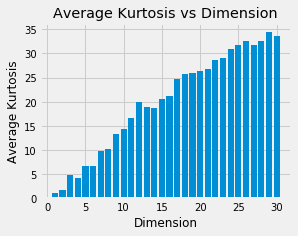

In [131]:
#plt.plot(kurts)
plt.bar(range(1, 31), kurts)
plt.xlabel('Dimension')
plt.ylabel('Average Kurtosis')
plt.title('Average Kurtosis vs Dimension')
plt.show()

In [132]:
acc=[]
for i in range (1, 31):
    ica = FastICA(n_components=i, whiten=True)
    X_ica =ica.fit_transform(X)
    #clf = DecisionTreeClassifier(max_depth=5)
    clf = KNeighborsClassifier()
    clf.fit(X_ica, y)
    acc.append(clf.score(X_ica, y))

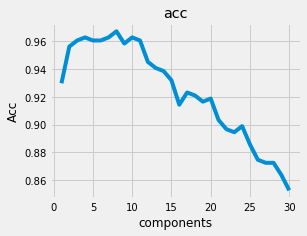

In [133]:
plt.plot(range(1, 31), acc)
plt.xlabel('components')
plt.ylabel('Acc')
plt.title('acc')
plt.show()

plt.clf()

In [134]:
ica = FastICA(n_components=8, whiten=True)
X_ica =ica.fit_transform(X)
kurts = kurtosis(X_ica)
print kurts

[  6.49768291   0.91716685  38.87537288  10.73448172   2.64855732
   3.93281416   0.94599448  17.79405334]


## 2.3 Random Projection

### RP parameter

In [135]:
acc1=[]
for i in range(1, 31):
    rp1 = SparseRandomProjection(n_components=i, random_state=10)
    X_rp1 =rp1.fit_transform(X)
    #clf = DecisionTreeClassifier(max_depth=5)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_rp1, y)
    acc1.append(clf.score(X_rp1, y))

acc2=[]
for i in range(1, 31):
    rp2 = SparseRandomProjection(n_components=i, random_state=20)
    X_rp2 =rp2.fit_transform(X)
    #clf = DecisionTreeClassifier(max_depth=5)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_rp2, y)
    acc2.append(clf.score(X_rp2, y))

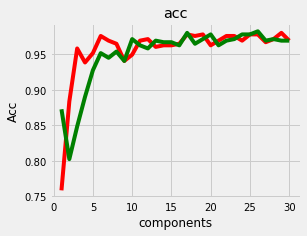

In [136]:
plt.plot(range(1, 31), acc1, color='r')
plt.plot(range(1, 31), acc2, color='g')

plt.xlabel('components')
plt.ylabel('Acc')
plt.title('acc')
plt.show()

In [137]:
variation
acc1=[]
var =[]
for i in range(1, 31):
    acc=[]
    for rand in range(100):
        rp1 = SparseRandomProjection(n_components=i, random_state=rand)
        X_rp1 =rp1.fit_transform(X)
        #clf = DecisionTreeClassifier(max_depth=5)
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_rp1, y)
        acc.append(clf.score(X_rp1, y))
    acc1.append(np.average(acc))
    var.append(variation(acc))

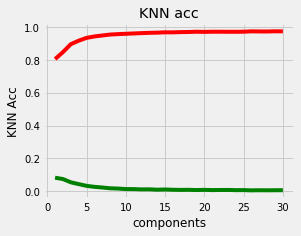

In [138]:
plt.plot(range(1, 31), acc1, color='r')
plt.plot(range(1, 31), var, color='g')

plt.xlabel('components')
plt.ylabel('KNN Acc')
plt.title('KNN acc')
plt.show()

## 2.4 LDA

In [139]:
score = []
lda=[]
lda.append(LDA().fit(X,y)) # default solver='svd'
lda.append(LDA(solver='lsqr', shrinkage='auto').fit(X, y))
lda.append(LDA(solver='lsqr', shrinkage=None).fit(X, y))
lda.append(LDA(solver='eigen', shrinkage='auto').fit(X, y))
lda.append(LDA(solver='eigen', shrinkage=None).fit(X, y))
for i in range(len(lda)):
    score.append(lda[i].score(X,y))

In [140]:
print score

[0.96923076923076923, 0.97142857142857142, 0.96923076923076923, 0.94945054945054941, 0.62637362637362637]


# 3. Clustering with DR

### PCA - original

time:  0.00203490257263


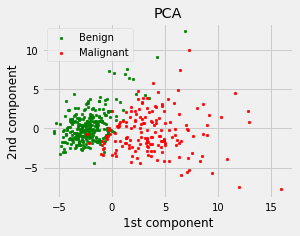

In [141]:
# PCA Plot
start = time()
X_pca = PCA(n_components=12).fit_transform(X)
print 'time: ', time() - start

k = 2 # number of clusters
colors = ['g', 'r', 'b', 'y', 'c', 'm']
labels = ['Benign', 'Malignant']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
#points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_EM[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('PCA')

time:  0.0275881290436
wrongly labeled: 0.90989010989


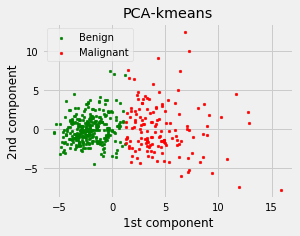

In [142]:
# PCA-kmeans Plot
start = time()
clf = KMeans(init='k-means++', n_clusters=2, random_state=42)
clf.fit_predict(X_pca)
print 'time: ', time() - start

k = 2 # number of clusters
colors = ['g', 'r', 'b', 'y', 'c', 'm']
labels = ['Benign', 'Malignant']

# fix labels
clusters_kmeans = np.choose(clf.labels_, [1, 0])

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if clf.labels_[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_kmeans[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('PCA-kmeans')
print 'wrongly labeled:', 1.0*len(points)/len(X)

### PCA - EM

time:  0.00697612762451
wrongly labeled: 0.881318681319


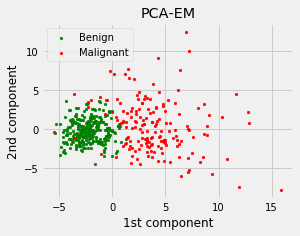

In [143]:
# PCA-EM Plot
start = time()
clf = GMM(n_components=2, covariance_type='spherical', random_state=42)
clf.fit(X)
clusters_ = clf.predict(X)
print 'time: ', time() - start

# fix labels
clusters_EM = np.choose(clusters_, [1, 0])

k = 2 # number of clusters
colors = ['g', 'r', 'b', 'y', 'c', 'm']
labels = ['Benign', 'Malignant']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if clusters_[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

# wrongly labeled points
points = np.array([X[j] for j in range(len(X)) if y[j] != clusters_EM[j]])
#ax.scatter(points[:, 1], points[:, 2], s=80, facecolors='none', edgecolors='m', label='Wrongly Labeled')
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('PCA-EM')
print 'wrongly labeled:', 1.0*len(points)/len(X)

# 4. Neural Networks with DR

## MLP helper function

In [144]:
# mlp learner helper function
def mlp_learner(input_layer_size, X_train, X_test):
    # set learning_rate and momentum
    learning_rate = 0.1
    momentum = 0.5
    # hidden_layer_size = (input layer + output layer) / 2
    size = (input_layer_size + 2) / 2 
    
    # mlp classifier
    mlp = MLPClassifier(hidden_layer_sizes=(size,),
                        solver='sgd',
                        learning_rate_init=learning_rate, 
                        momentum=momentum,
                        max_iter=10000)
    start = time()
    clf = mlp.fit(X_train, y)
    train_time = time() - start

    # train
    y_predict = clf.predict(X_train)
    train_acc = accuracy_score(y, y_predict)

    # test
    y_test_predict = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_predict)
    
    # return
    return train_acc, test_acc, train_time

## 4.0 Original MLP

In [145]:
train_acc, test_acc, train_time = mlp_learner(30, X, X_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.993406593407
test acc:  0.938596491228
train time:  0.198593139648


## 4.1 PCA - MLP

In [146]:
pca = PCA(n_components=12)
pca.fit(X)
X_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)

In [147]:
# pca
train_acc, test_acc, train_time = mlp_learner(12, X_pca, X_test_pca)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.991208791209
test acc:  0.956140350877
train time:  0.168452978134


## 4.1 ICA - MLP

In [148]:
ica = FastICA(n_components=8, whiten=True)
ica.fit(X)
X_ica =ica.transform(X)
X_ica_test = ica.transform(X_test)

In [155]:
# ica
train_acc, test_acc, train_time = mlp_learner(8, X_ica, X_ica_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.942857142857
test acc:  0.947368421053
train time:  0.331877946854


## 4.3 Random Projection - MLP

In [156]:
rp = SparseRandomProjection(n_components=5, random_state=20)

In [160]:
X_rp=[]
X_rp_test=[]
var =[]
for rand in range(100):
    rp = SparseRandomProjection(n_components=5, random_state=rand)
    rp.fit(X)
    X_rp.append(rp.transform(X))
    X_rp_test.append(rp.transform(X_test))

X_rp_mean = np.mean(X_rp,axis=0)
X_rp_test_mean = np.mean(X_rp_test, axis=0)
print X_rp_mean.shape
print X_rp_test_mean.shape

(455, 5)
(114, 5)


In [162]:
# rp
train_acc, test_acc, train_time = mlp_learner(5, X_rp_mean, X_rp_test_mean)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.940659340659
test acc:  0.894736842105
train time:  0.214676856995


# 5. Neural Networks with Clustering

In [163]:
# original MLP
train_acc, test_acc, train_time = mlp_learner(30, X, X_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.993406593407
test acc:  0.956140350877
train time:  0.253879070282


## 5.1 Kmeans as new feature

In [164]:
# K means with 2 cluster
kmeans1 = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans1.fit(X)
feature_kmeans1 = kmeans1.predict(X)
feature_kmeans1_test = kmeans1.predict(X_test)

In [165]:
# feature_kmeans1 as new additional feature
X_orig_kmeans1 = np.column_stack((X, feature_kmeans1))
X_orig_kmeans1_test = np.column_stack((X_test, feature_kmeans1_test))
train_acc, test_acc, train_time = mlp_learner(31, X_orig_kmeans1, X_orig_kmeans1_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.991208791209
test acc:  0.947368421053
train time:  0.188591957092


In [166]:
# feature_kmeans1 as the only feature
X_kmeans1 = X_orig_kmeans1[:,-1:]
X_kmeans1_test = X_orig_kmeans1_test[:,-1:]
train_acc, test_acc, train_time = mlp_learner(1, X_kmeans1, X_kmeans1_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.90989010989
test acc:  0.877192982456
train time:  0.0526869297028


In [167]:
# K means with k clusters (5 different k)
k = [2,4,6,8,10]
features = []
features_test = []
for i in range(len(k)):
    kmeans = KMeans(init='k-means++', n_clusters=k[i], n_init=10)
    kmeans.fit(X)
    features.append(kmeans.predict(X))
    features_test.append(kmeans.predict(X_test))

# 5 features only
X_kmeans5 = np.column_stack((features[0],features[1],features[2],
                             features[3],features[4]))
X_kmeans5_test = np.column_stack((features_test[0],features_test[1],features_test[2],
                                  features_test[3],features_test[4]))

# 5 features as new additional feature
X_orig_kmeans5 = np.column_stack((X, X_kmeans5))
X_orig_kmeans5_test = np.column_stack((X_test, X_kmeans5_test))

In [171]:
# 5 features only - mlp
train_acc, test_acc, train_time = mlp_learner(5, X_kmeans5, X_kmeans5_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.940659340659
test acc:  0.921052631579
train time:  0.0591769218445


In [172]:
# 5 features as new additional feature - mlp
train_acc, test_acc, train_time = mlp_learner(35, X_orig_kmeans5, X_orig_kmeans5_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.993406593407
test acc:  0.947368421053
train time:  0.0940878391266


## 5.2 EM as new Feature

In [173]:
# EM with 2 cluster
gmm1 = GMM(n_components=2, covariance_type='spherical')
gmm1.fit(X)
feature_gmm1 = gmm1.predict(X)
feature_gmm1_test = gmm1.predict(X_test)

In [174]:
# feature_gmm1 as new additional feature
X_orig_gmm1 = np.column_stack((X, feature_gmm1))
X_orig_gmm1_test = np.column_stack((X_test, feature_gmm1_test))
train_acc, test_acc, train_time = mlp_learner(31, X_orig_gmm1, X_orig_gmm1_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.993406593407
test acc:  0.947368421053
train time:  0.192206859589


In [175]:
# feature_gmm1 as the only feature
X_gmm1 = X_orig_gmm1[:,-1:]
X_gmm1_test = X_orig_gmm1_test[:,-1:]
train_acc, test_acc, train_time = mlp_learner(1, X_gmm1, X_gmm1_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.881318681319
test acc:  0.850877192982
train time:  0.0643169879913


In [176]:
# EM with k clusters (5 different k)
k = [2,4,6,8,10]
features = []
features_test = []
for i in range(len(k)):
    gmm = GMM(n_components=2, covariance_type='spherical')
    gmm.fit(X)
    features.append(gmm.predict(X))
    features_test.append(gmm.predict(X_test))

# 5 features only
X_gmm5 = np.column_stack((features[0],features[1],features[2],
                             features[3],features[4]))
X_gmm5_test = np.column_stack((features_test[0],features_test[1],features_test[2],
                                  features_test[3],features_test[4]))

# 5 features as new additional feature
X_orig_gmm5 = np.column_stack((X, X_gmm5))
X_orig_gmm5_test = np.column_stack((X_test, X_gmm5_test))

In [177]:
# 5 features only - mlp
train_acc, test_acc, train_time = mlp_learner(5, X_gmm5, X_gmm5_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.881318681319
test acc:  0.850877192982
train time:  0.0766968727112


In [178]:
# 5 features as new additional feature - mlp
train_acc, test_acc, train_time = mlp_learner(35, X_orig_gmm5, X_orig_gmm5_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.993406593407
test acc:  0.956140350877
train time:  0.264503002167
